# **User Segmentation and App Uninstall Prediction**

---

### **Project Overview**
This project aims to analyze user behavior on a mobile application to identify distinct types of user segments and further predict whether a user will uninstall the app. Using machine learning models such as **Kmeans**, we classify users based on various behavioral metrics, including screen time, spending patterns, and engagement levels. Later, we use  **Random Forest** and **XGBoost** to predict the app uninstallations using the same features.

### **Objective**
- Identify key factors influencing user retention and churn.
- Use clustering techniques to segment users based on behavior.
- Train machine learning models to predict whether a user will uninstall the app.
- Implement an interactive system where users can input their data to get predictions.

---

### 1. Importing Libraries & Loading Data

In [1]:
# Importing Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.cluster import KMeans
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")
pio.templates.default = "plotly_white"

In [2]:
raw_data = pd.read_csv("data/userbehaviour.csv")
print(raw_data.head())

   userid  Average Screen Time  Average Spent on App (INR)  Left Review  \
0    1001                 17.0                       634.0            1   
1    1002                  0.0                        54.0            0   
2    1003                 37.0                       207.0            0   
3    1004                 32.0                       445.0            1   
4    1005                 45.0                       427.0            1   

   Ratings  New Password Request  Last Visited Minutes       Status  
0        9                     7                  2990    Installed  
1        4                     8                 24008  Uninstalled  
2        8                     5                   971    Installed  
3        6                     2                   799    Installed  
4        5                     6                  3668    Installed  


### 2. Understanding the Dataset

**userid:** The identity number of the user.

**Average Screen Time:** The average screen time (in mins.) of the user on the application.

**Average Spent on App (INR):** The average amount spent by the user on the application.

**Left Review:** Did the user leave any reviews about the experience on the application? (1 if Yes, otherwise 0)

**Ratings:** Ratings given by the user to the application.

**New Password Request:** The number of times the user requested a new password.

**Last Visited Minutes:** Minuted passed by when the user was last active.

**Status:** Installed if the application is installed and uninstalled if the user has deleted the application.

In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   userid                      999 non-null    int64  
 1   Average Screen Time         999 non-null    float64
 2   Average Spent on App (INR)  999 non-null    float64
 3   Left Review                 999 non-null    int64  
 4   Ratings                     999 non-null    int64  
 5   New Password Request        999 non-null    int64  
 6   Last Visited Minutes        999 non-null    int64  
 7   Status                      999 non-null    object 
dtypes: float64(2), int64(5), object(1)
memory usage: 62.6+ KB


In [4]:
raw_data.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,999.0,1500.000000,288.530761,1001.0,1250.5,1500.0,1749.5,1999.0
Average Screen Time,999.0,24.390390,14.235415,0.0,12.0,24.0,36.0,50.0
Average Spent on App (INR),999.0,424.415415,312.365695,0.0,96.0,394.0,717.5,998.0
Left Review,999.0,0.497497,0.500244,0.0,0.0,0.0,1.0,1.0
Ratings,999.0,6.513514,2.701511,0.0,5.0,7.0,9.0,10.0
New Password Request,999.0,4.941942,2.784626,1.0,3.0,5.0,7.0,15.0
Last Visited Minutes,999.0,5110.898899,8592.036516,201.0,1495.5,2865.0,4198.0,49715.0


### 3. Data Visualization

#### 3.1 Average Screen Time Analysis

We analyze the distribution of screen time among users who have installed vs. uninstalled the app.

In [5]:
# Plot Average screen time for installed and uninstalled 
fig = px.histogram(raw_data, x="Average Screen Time", color="Status", barmode="group",
                   title="Average screen time for installed and uninstalled")
fig.update_layout(xaxis_title="Average screen time",
                    yaxis_title="Count",
                    legend_title_text="Status",
                    xaxis=dict(tickmode='linear', dtick=1))
fig.show()

Insight: Users who uninstalled the app generally have much lower screen time.

#### 3.2 Relationship Between Screen Time & Spending

We visualize how screen time correlates with spending.

In [6]:
# Scatter plot for Average screen time vs. Average spend on App

fig = px.scatter(raw_data, x="Average Screen Time", y="Average Spent on App (INR)",
                     color="Status", 
                     title="Average screen time vs. Average spend on App",
                     trendline="ols")
fig.update_layout(xaxis_title="Average screen time",
                    yaxis_title="Average spend on App (INR)",
                    legend_title_text="Status",
                    width=800, height=500)

fig.show()

Insight: Some users spent money but still uninstalled the app, suggesting dissatisfaction despite financial engagement.

### 3.3 Correlation Matrix

We explore the relationships between variables.

In [7]:
# Preprocessing the data
# Mapping the 'Status' column to numeric values (0 = Uninstalled, 1 = Installed)
data = raw_data.copy()

status_mapping = {
    'Uninstalled': 0,
    'Installed': 1
}

data['Status'] = data['Status'].map(status_mapping)

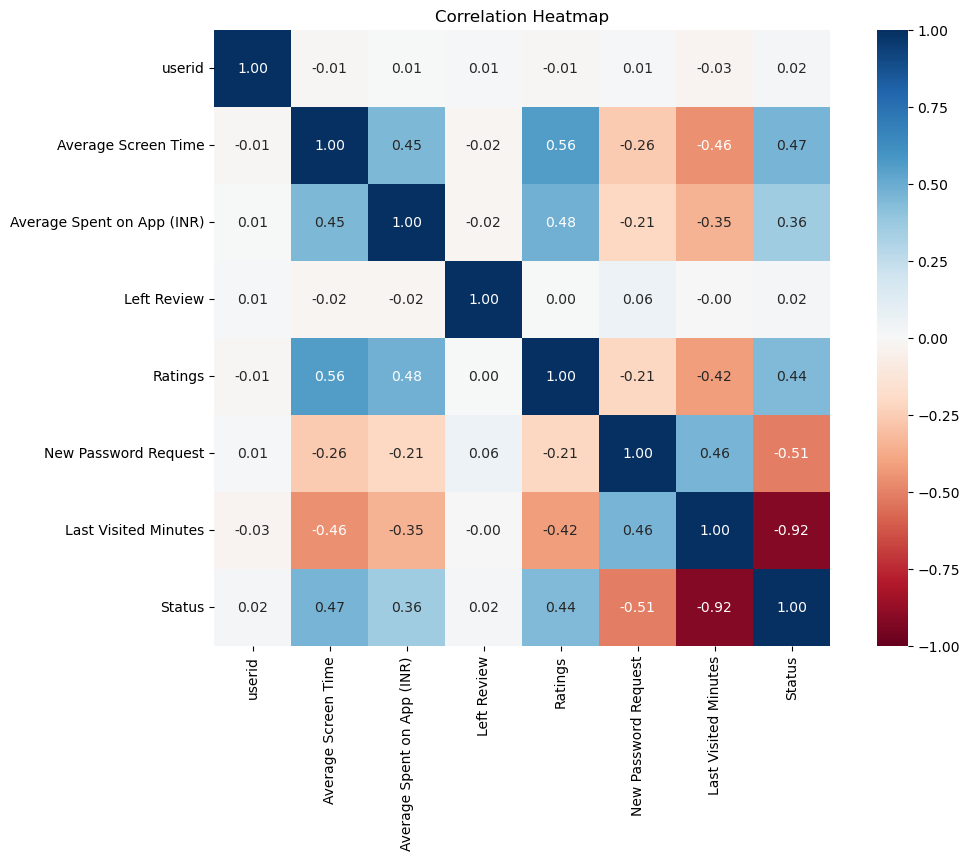

In [8]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap="RdBu", cbar=True, square=True, vmax=1, vmin=-1)
plt.title("Correlation Heatmap")
plt.show()

Insight: Last Visited Minutes has the highest correlation with Status, meaning the time since last usage strongly predicts churn.

### 4. User Segmentation Using K-Means Clustering

We segment users into behavioral groups.

In [9]:
clustering_data = data[["Average Screen Time", "Last Visited Minutes", "Average Spent on App (INR)"]]

scaler = MinMaxScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42, tol=1e-4)
data["Segments"] = kmeans.fit_predict(clustering_data_scaled)

# Map segment labels for better interpretation
data["Segments"] = data["Segments"].map({0: "Needs Attention", 1: "Retained", 2: "Churn"})

# Display first few rows with new segment column
print(data.head())

   userid  Average Screen Time  Average Spent on App (INR)  Left Review  \
0    1001                 17.0                       634.0            1   
1    1002                  0.0                        54.0            0   
2    1003                 37.0                       207.0            0   
3    1004                 32.0                       445.0            1   
4    1005                 45.0                       427.0            1   

   Ratings  New Password Request  Last Visited Minutes  Status  \
0        9                     7                  2990       1   
1        4                     8                 24008       0   
2        8                     5                   971       1   
3        6                     2                   799       1   
4        5                     6                  3668       1   

          Segments  
0         Retained  
1            Churn  
2  Needs Attention  
3  Needs Attention  
4  Needs Attention  


In [10]:
print(data["Segments"].value_counts())

Segments
Retained           392
Needs Attention    322
Churn              285
Name: count, dtype: int64


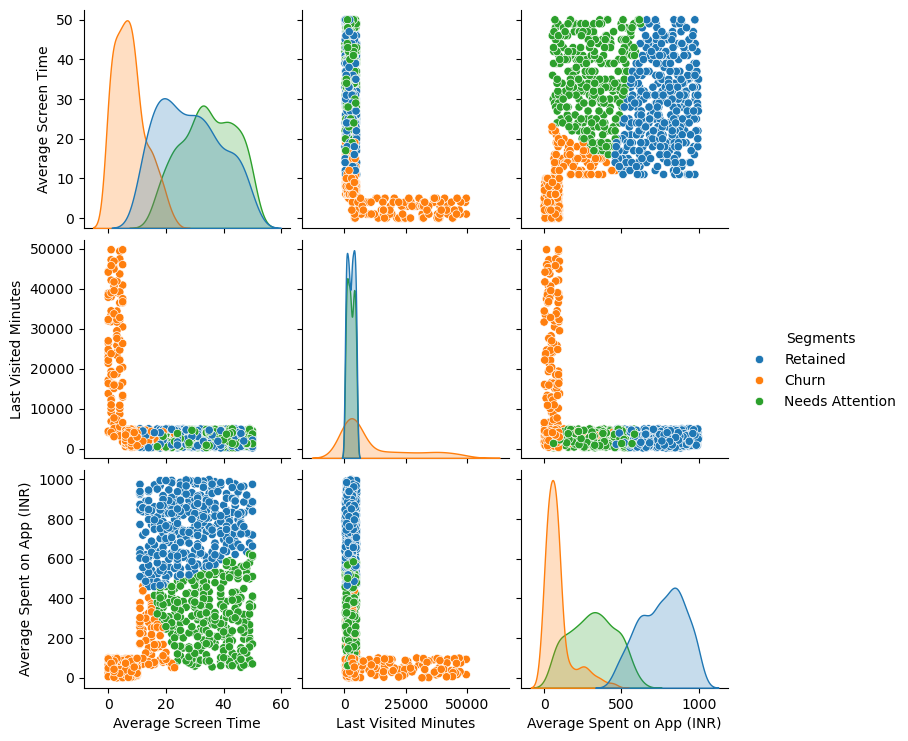

In [11]:
# Create a pairplot to visualize relationships between different features
sns.pairplot(data, hue='Segments', vars=['Average Screen Time', 'Last Visited Minutes', 'Average Spent on App (INR)'])
plt.show()

In [12]:
PLOT = go.Figure()
for i in list(data["Segments"].unique()):
    

    PLOT.add_trace(go.Scatter(x = data[data["Segments"]== i]['Average Screen Time'],
                                y = data[data["Segments"] == i]['Average Spent on App (INR)'],
                                mode = 'markers',marker_size = 10, marker_line_width = 0.5,
                                name = str(i)))
PLOT.update_traces(hovertemplate='Average Screen Time: %{x} <br>Average Spent on App (INR): %{y}')

    
PLOT.update_layout(width = 800, height = 600, autosize = True, showlegend = True,
                   yaxis_title = 'Average Spent on App (INR)',
                   xaxis_title = 'Average Screen Time',
                   scene = dict(xaxis=dict(title = 'Average Screen Time', titlefont_color = 'black'),
                                yaxis=dict(title = 'Average Spent on App (INR)', titlefont_color = 'black')))

In [13]:
PLOT = go.Figure()
for i in list(data["Segments"].unique()):
    

    PLOT.add_trace(go.Scatter(x = data[data["Segments"]== i]['Last Visited Minutes'],
                                y = data[data["Segments"] == i]['Average Spent on App (INR)'],
                                mode = 'markers',marker_size = 10, marker_line_width = 0.5,
                                name = str(i)))
PLOT.update_traces(hovertemplate='Last Visited Minutes: %{x} <br>Average Spent on App (INR): %{y}')

    
PLOT.update_layout(width = 800, height = 600, autosize = True, showlegend = True,
                   yaxis_title = 'Average Spent on App (INR)',
                   xaxis_title = 'Last Visited Minutes',
                   scene = dict(xaxis=dict(title = 'Last Visited Minutes', titlefont_color = 'black'),
                                yaxis=dict(title = 'Average Spent on App (INR)', titlefont_color = 'black')))

Key Takeaways:
- Retained users have moderate to high spending and frequent visits.
- Churn users barely use the app and have low spending.
- Users needing attention show mixed behavior and could be at risk.

### 5. Churn Prediction Using Machine Learning

#### 5.1 Data Preprocessing

In [14]:
print(f"Number of Installed cases: {data[data['Status'] == 1].shape[0]}")
print(f"Number of Uninstalled cases: {data[data['Status'] == 0].shape[0]}")

Number of Installed cases: 916
Number of Uninstalled cases: 83


We see that the number of installed cases are lot more than the uninstalled ones, inducing class imbalance. To prevent the model from learning a biased representation, we use stratified sampling to make sure that train and test sets have same class distribution as the original data.

In [15]:
# Features and target
X = data.drop(['userid', 'Status', 'Last Visited Minutes', 'Segments'], axis=1)  # Features
y = data['Status']  # Target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42, stratify=y)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### 5.2 Model Training & Evaluation

In [16]:
# Model Dictionary to store results
models = {
    "Random Forest": RandomForestClassifier(),
    "XGBoost": xgb.XGBClassifier()
}

# Training models and evaluating
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    print(f"Accuracy Score for {name}: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))


Training Random Forest...
Accuracy Score for Random Forest: 0.9775
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        66
           1       1.00      0.98      0.99       734

    accuracy                           0.98       800
   macro avg       0.89      0.99      0.93       800
weighted avg       0.98      0.98      0.98       800


Training XGBoost...
Accuracy Score for XGBoost: 0.97625
              precision    recall  f1-score   support

           0       0.78      1.00      0.87        66
           1       1.00      0.97      0.99       734

    accuracy                           0.98       800
   macro avg       0.89      0.99      0.93       800
weighted avg       0.98      0.98      0.98       800



Both the models have nearly same evaluation metrics and they balance recall & precision well (avoiding too many false positives or false negatives). However,
- XGBoost has perfect recall but may slightly overpredict uninstalls.
- Random Forest is very strong across all metrics with slightly better precision than XGBoost.

Thus, if the main goal is to detect all uninstalls, one should pick **XGBoost**. Otherwise, for a more balanced approach, **Random Forest** is better.

#### 6. User Input for Prediction

In [17]:
# Take input from user
def take_input():
    print("Enter the following details:")
    average_screen_time = float(input("Average Screen Time (in mins.): "))
    left_review = int(input("Left Review (1 for Yes, 0 for No): "))
    ratings = float(input("Ratings (0 to 10): "))
    average_spent_on_app = float(input("Average Spent on App (INR): "))
    new_password_request = int(input("New Password Request (1 for Yes, 0 for No): "))

    return np.array([[average_screen_time, average_spent_on_app, left_review,
                      ratings, new_password_request]])

# Scaling the input data
input_data = take_input()

input_df = pd.DataFrame(input_data, columns=X.columns)

input_data_scaled = scaler.transform(input_data)

# Predicting the status
predicted_status = models['Random Forest'].predict(input_data_scaled)

print(f"Predicted Status: {'Installed' if predicted_status[0] == 1 else 'Uninstalled'}")

Enter the following details:
Predicted Status: Installed


### 7. Conclusion & Insights
- Screen time and spending patterns play a key role in app retention.
- Last Visited Minutes is the strongest predictor of whether a user will uninstall the app.
- Users can be segmented into three groups: Retained, Churn, and Needs Attention.
- XGBoost is ideal for recall (detecting all uninstalls), while Random Forest provides balanced performance.

Final Recommendation: Use targeted retention strategies for users in the “Needs Attention” segment to reduce churn.